In [1]:
num_docs = 10000
num_docs_bis = 5000
num_topics = 2
vocab_size = 1000
min_words = 50
max_words = 100
num_covs = 1
update_prior = True
doc_topic_prior = 'logistic_normal'
w_prior = 1
num_epochs = 1000
num_iter = 1
patience = 1
dropout = 0
num_jobs = 4
test_set = False
encoder_include_prevalence_covariates = True
print_every_n_epochs = 1

In [2]:
import numpy as np
if doc_topic_prior == 'logistic_normal':
    lambda_ = np.array(
        [[0,0.3],
        [0,-0.4]]
    )
    sigma = np.array(
        [[1.7,-0.3],
        [-0.3,2.3]]
    )
else:
    lambda_ = np.array(
        [[-2,0.01],
        [-2,0.02]]
    )
    sigma = None

In [3]:
import sys
sys.path.append('../gtm/')
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from random import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import GTMCorpus
from gtm import GTM
from joblib import Parallel, delayed

/home/germain/Documents/topic models/generalized_topic_model_dev/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def generate_doc(
    i, true_doc_topic_matrix, topic_word_matrix, min_words, max_words
):
    doc_length = np.random.randint(min_words, max_words+1)
    doc_topic_matrix = true_doc_topic_matrix[i]
    doc_words = []
    for _ in range(doc_length):
        word_probs = np.dot(doc_topic_matrix, topic_word_matrix)
        word_probs /= np.sum(word_probs)
        word_index = np.random.choice(vocab_size, p=word_probs)
        doc_words.append('word_' + str(word_index))            
    doc = ' '.join(doc_words)
    return doc


def generate_documents(
    num_docs, 
    num_topics, 
    vocab_size, 
    num_covs,
    lambda_, 
    sigma,
    doc_topic_prior,
    min_words=50, 
    max_words=100, 
    random_seed=None,
    num_jobs=1
):

    topicnames = ["Topic" + str(i) for i in range(num_topics)]
    docnames = ["Doc" + str(i) for i in range(num_docs)]
    words = ["word_" + str(i) for i in range(vocab_size)]
    cov_names = ["cov_" + str(i) for i in range(num_covs + 1)]
    
    if random_seed is not None:
        np.random.seed(random_seed)

    if num_covs > 0:
        M_prevalence_covariates = np.zeros((num_docs, num_covs + 1), dtype=int)
        M_prevalence_covariates[:, 0] = 1
        for i in range(num_covs):
            M_prevalence_covariates[:, i + 1] = np.random.randint(2, size=num_docs)
    
    if num_covs > 0:
        alpha = np.exp(np.dot(M_prevalence_covariates, lambda_))
    else:
        alpha = np.array([[0.1 for _ in range(num_topics)] for l in range(num_docs)])

    if doc_topic_prior == 'dirichlet':
        samples = []
        for a in alpha:
            sample = np.random.dirichlet(a)
            samples.append(sample)
        true_doc_topic_matrix = np.array(samples)
    else:
        if num_covs > 0:
            mean = np.dot(M_prevalence_covariates, lambda_)
        else:
            mean = np.array([[0 for _ in range(num_topics)] for l in range(num_docs)])
            sigma = np.eye(num_topics)
        samples = []
        for m in mean:
            sample = np.random.multivariate_normal(m, sigma)
            sample = np.exp(sample) / np.exp(sample).sum()
            samples.append(sample)
        true_doc_topic_matrix = np.array(samples)

    beta = [0.1 for _ in range(vocab_size)]
    topic_word_matrix = np.random.dirichlet(beta, num_topics)
    
    documents = Parallel(n_jobs=num_jobs)(
        delayed(generate_doc)(
            i,
            true_doc_topic_matrix, 
            topic_word_matrix,
            min_words,
            max_words,
        )
        for i in range(num_docs)
    )  

    temp = pd.DataFrame({"doc": documents, "doc_clean": documents})
    if num_covs > 0:
        df = pd.concat([temp, pd.DataFrame(M_prevalence_covariates)], axis=1)
        df.columns = ["doc", "doc_clean"] + cov_names
    else:
        df = temp
        df.columns = ["doc", "doc_clean"] 
    
    df_doc_topic = pd.DataFrame(true_doc_topic_matrix, columns=topicnames, index=docnames)
    df_topic_word = pd.DataFrame(topic_word_matrix, index=topicnames, columns=words)

    df_true_dist_list = [df_doc_topic, df_topic_word]
    
    return df_true_dist_list, df

In [5]:
cossim_list = []
true_doc_topic_list = []
estimated_doc_topic_list = []

dict_betas = {}

if num_covs > 0:
    dict_betas = {}
    for i in range(num_topics):
        dict_betas[i] = {}
        for c in range(num_covs+1):
            dict_betas[i][c] = []

for i in tqdm(range(num_iter)):
    
    gtm_model_args = {
        "n_topics":num_topics,
        "num_epochs":num_epochs,
        "update_prior":update_prior,
        "doc_topic_prior":doc_topic_prior,
        "w_prior":w_prior,
        "patience":patience,
        "print_every_n_epochs":print_every_n_epochs,
        "encoder_include_prevalence_covariates":encoder_include_prevalence_covariates,
        "dropout":dropout,
        "encoder_hidden_layers":[256],
        "decoder_hidden_layers":[256],
        "batch_size":64,
        "learning_rate":1e-4
        }
    
    df_true_dist_list_gtm, df = generate_documents(
        num_docs, 
        num_topics, 
        vocab_size, 
        num_covs,
        lambda_, 
        sigma,
        doc_topic_prior,
        min_words=min_words, 
        max_words=max_words, 
        random_seed=i,
        num_jobs=num_jobs
    )  

    if test_set and num_covs > 0:       
        train = df.sample(frac=0.8,random_state=42)
        test = df.drop(train.index).reset_index(drop=True)
        train = train.reset_index(drop=True)

        full_dataset = GTMCorpus(
            df,
            prevalence = "~ cov_0 + cov_1 - 1"
        )     
        train_dataset = GTMCorpus(
            train,
            prevalence = "~ cov_0 + cov_1 - 1",
            vectorizer = full_dataset.vectorizer
        )      
        test_dataset = GTMCorpus(
            test,
            prevalence = "~ cov_0 + cov_1 - 1",
            vectorizer = full_dataset.vectorizer 
        )
        
    elif test_set and num_covs == 0:
        train = df.sample(frac=0.8,random_state=42)
        test = df.drop(train.index).reset_index(drop=True)
        train = train.reset_index(drop=True)

        full_dataset = GTMCorpus(
            df,
        )    
        train_dataset = GTMCorpus(
            train,
            vectorizer = full_dataset.vectorizer
        )    
        test_dataset = GTMCorpus(
            test,
            vectorizer = full_dataset.vectorizer 
        )
        
    elif test_set is False and num_covs > 0:
        full_dataset = GTMCorpus(
            df,
            prevalence = "~ cov_0 + cov_1 - 1"
        )
        
    else:
        full_dataset = GTMCorpus(
            df,
        )
        
    if test_set:        
        tm = GTM(
            train_data = train_dataset,
            test_data = test_dataset,
            **gtm_model_args
        )
        
    else:
        tm = GTM(
            train_data = full_dataset,
            **gtm_model_args
        )
        
    df_doc_topic_gtm = pd.DataFrame(
            tm.get_doc_topic_distribution(full_dataset),
            index=["Doc{}".format(i) for i in range(num_docs)],
            columns=["Topic{}".format(i) for i in range(num_topics)],
        )
    true_df = df_true_dist_list_gtm[0]
    estimated_df = df_doc_topic_gtm

    ### matching the columns of estimated doc_topic dist with those of true doc_topic dist by maximizing dot-product
    score_list = []
    for true_col in true_df.columns:
        true_target_col = true_df.loc[:, true_col]
        score_list_per_row = []
        for col in estimated_df.columns:
            target_col = estimated_df.loc[:, col]
            score_list_per_row.append(np.dot(target_col, true_target_col))
        score_list.append(score_list_per_row)
    corres_num_topic_dict_gtm = {}
    corres_num_topic_dict_gtm_bis = {}
    score_matrix = pd.DataFrame(score_list)
    true_topics, estimated_topics = linear_sum_assignment(-score_matrix)
    for true_topic, estimated_topic in zip(true_topics, estimated_topics):
        corres_num_topic_dict_gtm["Topic{}".format(true_topic)] = "Topic{}".format(
            estimated_topic
        )
        corres_num_topic_dict_gtm_bis[true_topic] = estimated_topic
    reanged_df_gtm = estimated_df.loc[:, corres_num_topic_dict_gtm.values()]
    reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

    true_doc_topic_list.append(true_df)
    estimated_doc_topic_list.append(reanged_df_gtm)

    if num_covs > 0:
        lambda_hat = tm.prior.lambda_
        lambda_hat = lambda_hat - lambda_hat[:, corres_num_topic_dict_gtm_bis[0]][:, None]
    
        for i in range(num_topics):
            for c in range(num_covs+1):
                dict_betas[i][c] = dict_betas[i][c] + [lambda_hat[c, corres_num_topic_dict_gtm_bis[i]]]    

  0%|                                                                                                                                              | 0/1 [00:00<?, ?it/s]


Epoch   1	Mean Training Loss:470.8557261

Topic_0: ['word_395', 'word_778', 'word_575', 'word_84', 'word_195', 'word_997', 'word_616', 'word_62']
Topic_1: ['word_395', 'word_331', 'word_65', 'word_861', 'word_777', 'word_275', 'word_954', 'word_992']



Epoch   2	Mean Training Loss:426.5506310

Topic_0: ['word_395', 'word_778', 'word_62', 'word_84', 'word_195', 'word_180', 'word_638', 'word_954']
Topic_1: ['word_395', 'word_205', 'word_389', 'word_297', 'word_861', 'word_180', 'word_331', 'word_485']



Epoch   3	Mean Training Loss:412.4362585

Topic_0: ['word_395', 'word_778', 'word_62', 'word_638', 'word_702', 'word_180', 'word_954', 'word_195']
Topic_1: ['word_205', 'word_389', 'word_297', 'word_485', 'word_861', 'word_259', 'word_267', 'word_652']



Epoch   4	Mean Training Loss:408.1586825

Topic_0: ['word_395', 'word_778', 'word_702', 'word_62', 'word_638', 'word_180', 'word_954', 'word_195']
Topic_1: ['word_205', 'word_389', 'word_297', 'word_485', 'word_259', 'word_267', 'word

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:05<00:00, 185.67s/it]


In [6]:
import pickle as pk 
results = {
    "dict_betas":dict_betas,
    "true_doc_topic_list":true_doc_topic_list, 
    "estimated_doc_topic_list":estimated_doc_topic_list
}
with open('monte_carlo_simulations.pkl', 'wb') as f:
    pk.dump(results, f)

with open("monte_carlo_simulations.pkl", "rb") as f:
    results = pk.load(f)

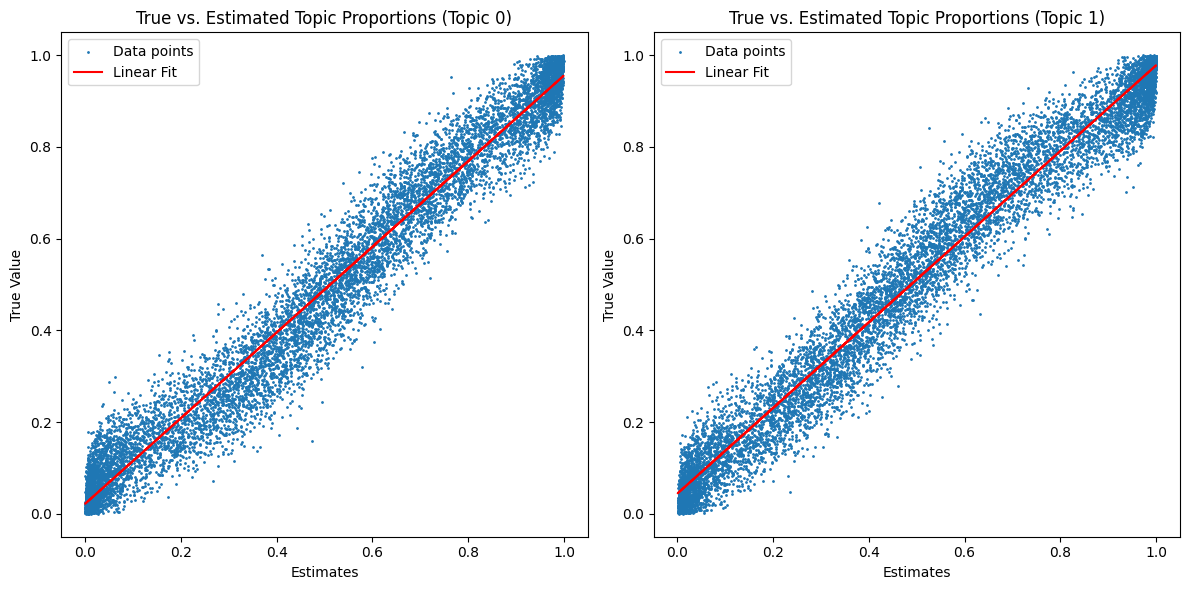

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

for i in range(2):  
    x = estimated_doc_topic_list[0]['Topic{}'.format(i)]
    y = true_doc_topic_list[0]['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, label='Data points', s=1)
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), color='red', label='Linear Fit')
    axs[i].set_xlabel('Estimates')
    axs[i].set_ylabel('True Value')
    axs[i].set_title('True vs. Estimated Topic Proportions (Topic {})'.format(i))
    axs[i].legend()

plt.tight_layout() 
plt.savefig('true_vs_estimated_sample_{}.png'.format(doc_topic_prior))

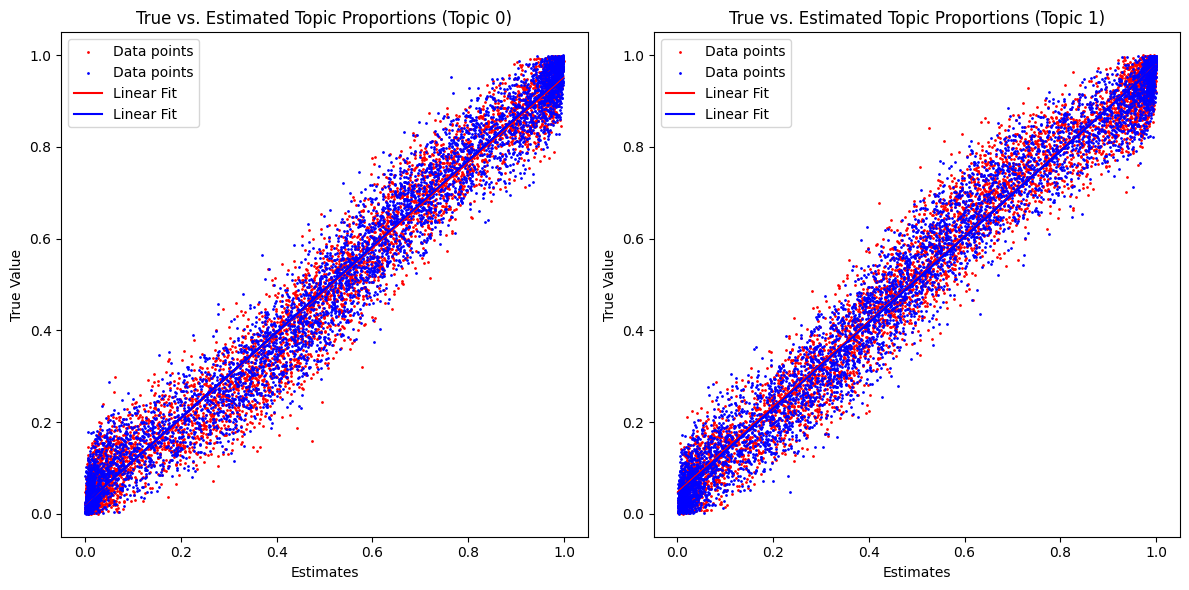

In [8]:
if num_covs > 0:
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 
    
    estimated_doc_topics = estimated_doc_topic_list[0]
    true_doc_topics = true_doc_topic_list[0]
    estimated_doc_topics['cov_1'] = list(df['cov_1'])
    true_doc_topics['cov_1'] = list(df['cov_1'])
    
    true_doc_topics_cov_0 = true_doc_topics[true_doc_topics['cov_1'] == 0]
    estimated_doc_topics_cov_0 = estimated_doc_topics[estimated_doc_topics['cov_1'] == 0]
    
    true_doc_topics_cov_1 = true_doc_topics[true_doc_topics['cov_1'] == 1]
    estimated_doc_topics_cov_1 = estimated_doc_topics[estimated_doc_topics['cov_1'] == 1]
    
    for i in range(2):  
        x0 = estimated_doc_topics_cov_0['Topic{}'.format(i)]
        y0 = true_doc_topics_cov_0['Topic{}'.format(i)]
    
        x1 = estimated_doc_topics_cov_1['Topic{}'.format(i)]
        y1 = true_doc_topics_cov_1['Topic{}'.format(i)]
        
        axs[i].scatter(x0, y0, label='Data points', s=1, color = 'red')
        axs[i].scatter(x1, y1, label='Data points', s=1, color = 'blue')
        coefficients = np.polyfit(x0, y0, 1)
        fit = np.poly1d(coefficients)
        axs[i].plot(x0, fit(x0), color='red', label='Linear Fit')
        coefficients = np.polyfit(x1, y1, 1)
        fit = np.poly1d(coefficients)
        axs[i].plot(x1, fit(x1), color='blue', label='Linear Fit')
        axs[i].set_xlabel('Estimates')
        axs[i].set_ylabel('True Value')
        axs[i].set_title('True vs. Estimated Topic Proportions (Topic {})'.format(i))
        axs[i].legend()
    
    plt.tight_layout() 
    plt.savefig('true_vs_estimated_sample_by_cov_{}.png'.format(doc_topic_prior))

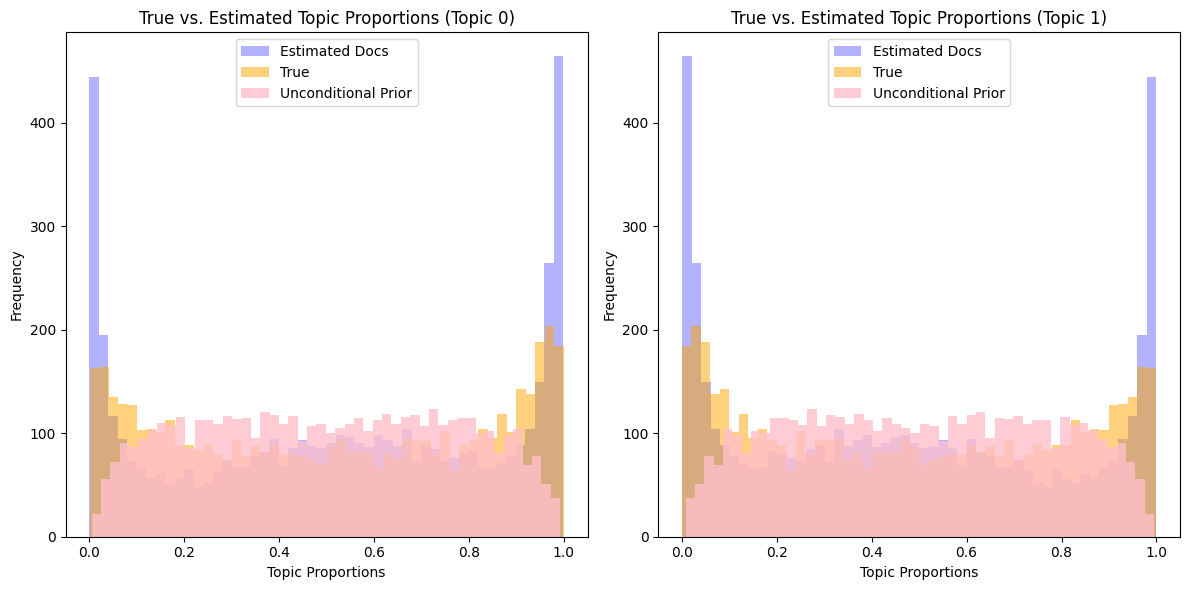

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

if doc_topic_prior == 'logistic_normal':
    mean2 = np.array([[0 for _ in range(num_topics)] for l in range(num_docs_bis)])
    sigma2 = np.eye(num_topics)
    samples = []
    for m in mean2:
        sample = np.random.multivariate_normal(m, sigma2)
        sample = np.exp(sample) / np.exp(sample).sum()
        samples.append(sample)
    z = np.array(samples)
else:
    alpha = np.array([[0.1 for _ in range(num_topics)] for l in range(num_docs_bis)])
    samples = []
    for a in alpha:
        sample = np.random.dirichlet(a)
        samples.append(sample)
    z = np.array(samples)

M_prevalence_covariates = np.zeros((num_docs_bis, num_covs + 1), dtype=np.float32)
M_prevalence_covariates[:, 0] = 1
for i in range(num_covs):
    M_prevalence_covariates[:, i + 1] = 1
if doc_topic_prior == 'logistic_normal':
    w = tm.prior.sample(N=num_docs_bis, M_prevalence_covariates=M_prevalence_covariates, to_simplex=True).cpu()
else:
    w = tm.prior.sample(N=num_docs_bis, M_prevalence_covariates=M_prevalence_covariates).cpu()
    
estimated_doc_topics = estimated_doc_topic_list[0]
true_doc_topics = true_doc_topic_list[0]

if num_covs > 0:
    estimated_doc_topics['cov_1'] = list(df['cov_1'])
    true_doc_topics['cov_1'] = list(df['cov_1'])
    true_doc_topics = true_doc_topics[true_doc_topics['cov_1'] == 1]
    estimated_doc_topics = estimated_doc_topics[estimated_doc_topics['cov_1'] == 1]

for i in range(2):
    x = estimated_doc_topics['Topic{}'.format(i)]
    y = true_doc_topics['Topic{}'.format(i)]

    axs[i].hist(x, bins=50, alpha=0.3, color='blue', label='Estimated Docs')
    axs[i].hist(y, bins=50, alpha=0.5, color='orange', label='True')
    axs[i].hist(z[:,i], bins=50, alpha=0.8, color='pink', label='Unconditional Prior')
    #axs[i].hist(w[:,i], bins=50, alpha=0.5, color='grey', label='Sampled Prior')
    axs[i].set_xlabel('Topic Proportions')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('True vs. Estimated Topic Proportions (Topic {})'.format(i))
    axs[i].legend()

plt.tight_layout()
plt.savefig('true_vs_estimated_sample_{}.png'.format(doc_topic_prior))

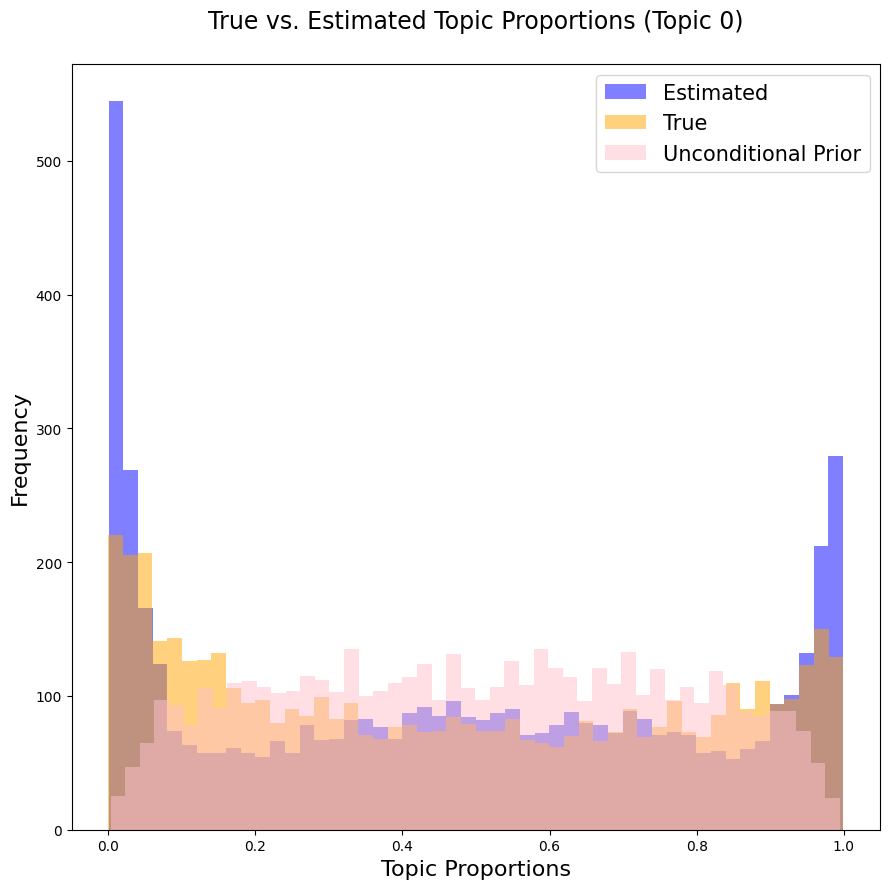

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(9, 9))

if doc_topic_prior == 'logistic_normal':
    mean2 = np.array([[0 for _ in range(num_topics)] for l in range(num_docs_bis)])
    sigma2 = np.eye(num_topics)
    samples = []
    for m in mean2:
        sample = np.random.multivariate_normal(m, sigma2)
        sample = np.exp(sample) / np.exp(sample).sum()
        samples.append(sample)
    z = np.array(samples)
else:
    alpha = np.array([[0.1 for _ in range(num_topics)] for l in range(num_docs_bis)])
    samples = []
    for a in alpha:
        sample = np.random.dirichlet(a)
        samples.append(sample)
    z = np.array(samples)

estimated_doc_topics = estimated_doc_topic_list[0]
true_doc_topics = true_doc_topic_list[0]

if num_covs > 0:
    estimated_doc_topics['cov_1'] = list(df['cov_1'])
    true_doc_topics['cov_1'] = list(df['cov_1'])
    true_doc_topics = true_doc_topics[true_doc_topics['cov_1'] == 0]
    estimated_doc_topics = estimated_doc_topics[estimated_doc_topics['cov_1'] == 0]

i = 0

x = estimated_doc_topics['Topic{}'.format(i)]
y = true_doc_topics['Topic{}'.format(i)]

axs.hist(x, bins=50, alpha=0.5, color='blue', label='Estimated')
axs.hist(y, bins=50, alpha=0.5, color='orange', label='True')
axs.hist(z[:,i], bins=50, alpha=0.5, color='pink', label='Unconditional Prior')
axs.set_xlabel('Topic Proportions',fontsize=16)
axs.set_ylabel('Frequency',fontsize=16)
axs.set_title('True vs. Estimated Topic Proportions (Topic {})\n'.format(i),fontsize=17)
axs.legend(fontsize=15)

plt.tight_layout()
plt.savefig('true_vs_estimated_sample_{}.pdf'.format(doc_topic_prior))

In [11]:
if num_covs > 0:
    print(tm.prior.lambda_)
    print(lambda_)
    if doc_topic_prior == 'logistic_normal':
        print(tm.prior.sigma)
        print(sigma)

tensor([[ 0.0000, -0.3391],
        [ 0.0000,  0.4653]], device='cuda:0')
[[ 0.   0.3]
 [ 0.  -0.4]]
tensor([[ 1.7051, -1.6930],
        [-1.6930,  1.6932]], device='cuda:0')
[[ 1.7 -0.3]
 [-0.3  2.3]]


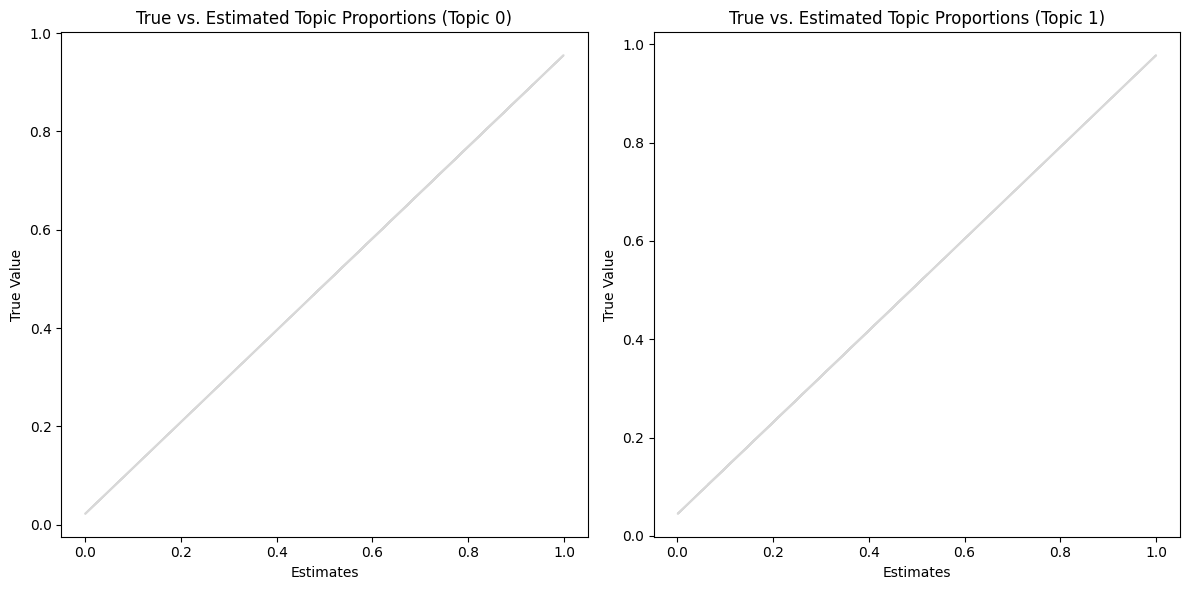

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

for i in range(2):  
    for j in range(num_iter):  
        x = estimated_doc_topic_list[j]['Topic{}'.format(i)]
        y = true_doc_topic_list[j]['Topic{}'.format(i)]

        coefficients = np.polyfit(x, y, 1)
        fit = np.poly1d(coefficients)
        axs[i].plot(x, fit(x), alpha=0.3, color='gray')  

    axs[i].set_xlabel('Estimates')
    axs[i].set_ylabel('True Value')
    axs[i].set_title('True vs. Estimated Topic Proportions (Topic {})'.format(i))

plt.tight_layout() 
plt.savefig('true_vs_estimated_all_samples_{}.png'.format(doc_topic_prior))

In [13]:
if num_covs > 0:
    for i in range(num_topics):
        for c in range(num_covs+1):
            if doc_topic_prior == 'dirichlet':
                data = dict_betas[i][c]
            else:
                data = [i.cpu().numpy() for i in dict_betas[i][c]]
            true_value = lambda_[c,i]
            mean = np.mean(data)
            se = np.std(data)
            print("Topic {} | Cov {}".format(i,c+1))
            print("True Value: {} | Mean: {} | SE: {}".format(
                true_value,
                mean,
                se))
            print('\n')

Topic 0 | Cov 1
True Value: 0.0 | Mean: 0.0 | SE: 0.0


Topic 0 | Cov 2
True Value: 0.0 | Mean: 0.0 | SE: 0.0


Topic 1 | Cov 1
True Value: 0.3 | Mean: 0.3391427993774414 | SE: 0.0


Topic 1 | Cov 2
True Value: -0.4 | Mean: -0.4652726650238037 | SE: 0.0




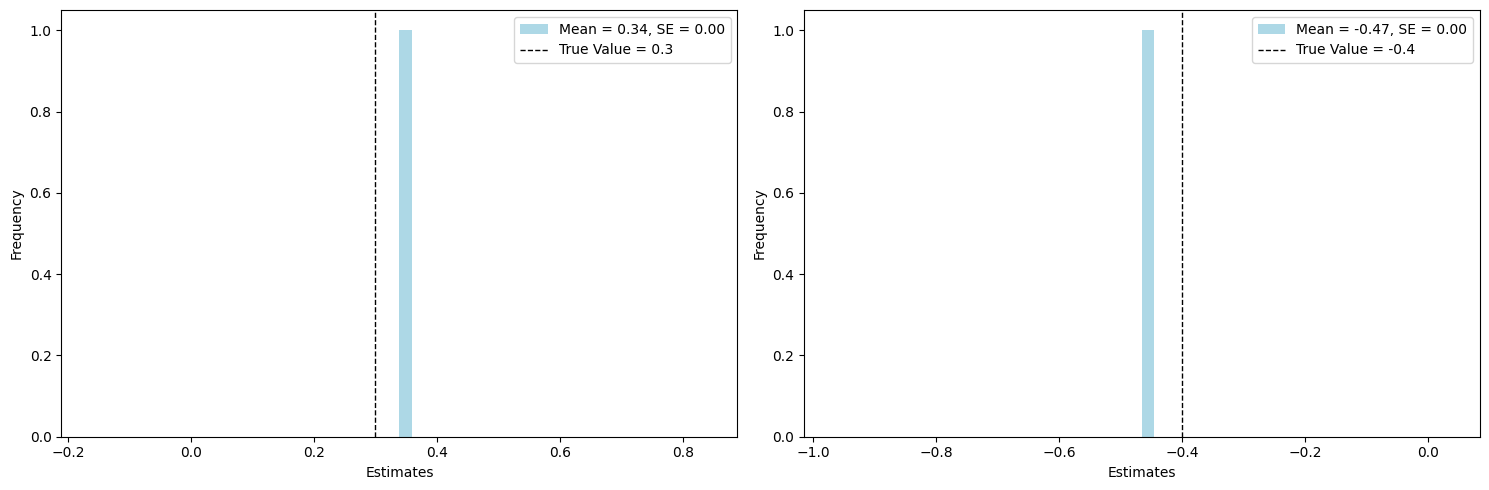

In [14]:
import numpy as np
import matplotlib.pyplot as plt

if num_covs > 0:

    fig, axes = plt.subplots(num_topics-1, num_covs + 1, figsize=(15, 5))
    
    for i in range(1,num_topics):
        for c in range(num_covs + 1):
            if doc_topic_prior == 'dirichlet':
                data = dict_betas[i][c]
            else:
                data = [i.cpu().numpy() for i in dict_betas[i][c]]
            mean = np.mean(data)
            se = np.std(data)
            ax = axes[c]
            ax.hist(data, bins=50, alpha=1, color='lightblue', label='Mean = {:.2f}, SE = {:.2f}'.format(mean,se))
            vertical_line_value = lambda_[c, i]
            ax.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=1,
                       label='True Value = {}'.format(vertical_line_value))
            ax.set_xlabel('Estimates')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    plt.tight_layout()
    plt.savefig('monte_carlos_barplots_{}.png'.format(doc_topic_prior))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

if num_covs > 0 and num_iter > 1:
    
    fig, axes = plt.subplots(num_topics-1, num_covs + 1, figsize=(15, 5))
    
    for i in range(1,num_topics):
        for c in range(num_covs + 1):
            if doc_topic_prior == 'dirichlet':
                data = dict_betas[i][c]
            else:
                data = [i.cpu().numpy() for i in dict_betas[i][c]]
            mean = np.mean(data)
            se = np.std(data)
            kde = gaussian_kde(data)
            x = np.linspace(min(data) - 1, max(data) + 1, 1000)
            ax = axes[c]
            ax.fill_between(x, kde(x), alpha=1, color='lightblue', label='Mean = {:.2f}, SE = {:.2f}'.format(mean,se))
            vertical_line_value = round(lambda_[c, i], 2)  
            ax.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=1,
                       label='True Value = {}'.format(vertical_line_value))
            ax.set_xlabel('Estimates')
            ax.set_ylabel('Density')
            ax.legend()
    
    plt.tight_layout()
    plt.savefig('monte_carlos_kde_plots_{}.png'.format(doc_topic_prior))